In [92]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
# baseline loss from character prediction
-torch.tensor(1/27).log() 

tensor(3.2958)

In [94]:
# plt.hist(h.view(-1).tolist(), 50);

In [95]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(-0.0052) tensor(0.9960)
tensor(-0.0016) tensor(0.9766)


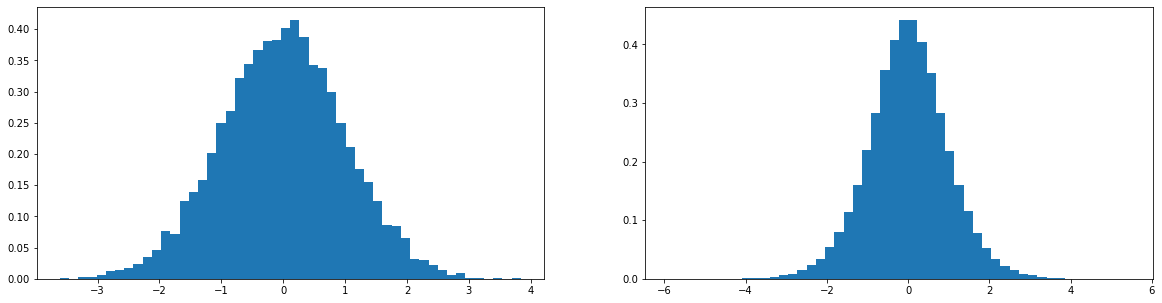

In [96]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [97]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [98]:
len(words)

32033

In [99]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [100]:
vocab_size = len(itos)

In [101]:
print(vocab_size)

27


In [102]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        # print(f"word is {w}")
        for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          # print(''.join([itos[i] for i in context]), itos[ix])
          context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [103]:
import random
random.seed(42)
random.shuffle(words)

In [104]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [105]:
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [106]:
# MLP revisited
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

In [107]:
W1.shape, W2.shape

(torch.Size([30, 200]), torch.Size([200, 27]))

In [108]:
# batchnorm params
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
sum(p.nelement() for p in parameters)

12097

In [109]:
for p in parameters:
    p.requires_grad = True

In [110]:
max_steps = 200_000
batch_size = 32
lossi = []

In [111]:
a = torch.randn((32, 200))
a.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [112]:
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # [32, 3, 10]
    embcat = emb.view(emb.shape[0], -1) # [32, 30]
    hpreact = embcat @ W1 # [32, 200]

    # batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain* ((hpreact - bnmeani)/bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # MLP -> BN -> tanh (check Resnet implementation in pytorch)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000  == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


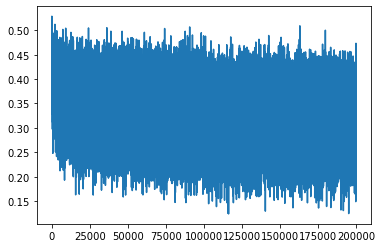

In [113]:
plt.plot(lossi)

In [114]:
# calibrate batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(Xtr.shape[0], -1)
    hpreact = embcat @ W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [115]:
bnmean.shape, bnstd.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [116]:
datasets = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
}

In [117]:
@torch.no_grad()
def split_loss(split):
    x,y = datasets[split]
    emb = C[x]
    embcat = emb.view(x.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [118]:
split_loss('train')

train 2.06659197807312


In [119]:
split_loss('val')

val 2.1050572395324707


In [183]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] if self.bias is None else [self.weight] + [self.bias]

In [184]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1- self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


In [185]:
from typing import Any


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [186]:
# Test own implmentation

In [257]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

In [258]:
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # tanh

In [259]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
sum(p.nelement() for p in parameters)

47024

In [260]:
for p in parameters:
    p.requires_grad = True

In [261]:
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # [32, 3, 10]
    embcat = emb.view(emb.shape[0], -1) # [32, 30]
    # print(f"embcat shape is {embcat.shape}")
    for layer in layers:
        embcat = layer(embcat)
        # print(embcat.shape)
    
    loss = F.cross_entropy(embcat, Yb)
    # print(loss)

    for layer in layers: # helps retain gradients for non leaf nodes
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    # for p in parameters:
    #     if p.grad is None:
    #         print(None, p.requires_grad)
    #     else:
    #         print(p.grad.shape)

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay

    for p in parameters:
        # print(f'grad is {p.grad}, {lr}')
        p.data += -lr * p.grad
    
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    # break


      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1043
  30000/ 200000: 1.9646
  40000/ 200000: 2.2144
  50000/ 200000: 2.2266
  60000/ 200000: 1.7339
  70000/ 200000: 2.1748
  80000/ 200000: 2.1895
  90000/ 200000: 1.8281
 100000/ 200000: 2.3635
 110000/ 200000: 2.2592
 120000/ 200000: 2.0968
 130000/ 200000: 1.8977
 140000/ 200000: 1.8304
 150000/ 200000: 1.9419
 160000/ 200000: 1.8676
 170000/ 200000: 1.8347
 180000/ 200000: 2.2491
 190000/ 200000: 2.0140


### Visualize histograms

In [247]:
a = torch.zeros((20, 20)).float()

In [248]:
ay, ax = torch.histogram(a, density=True)
ax.shape, ay.shape

(torch.Size([101]), torch.Size([100]))

In [249]:
ax

tensor([-5.0000e-01, -4.9000e-01, -4.8000e-01, -4.7000e-01, -4.6000e-01,
        -4.5000e-01, -4.4000e-01, -4.3000e-01, -4.2000e-01, -4.1000e-01,
        -4.0000e-01, -3.9000e-01, -3.8000e-01, -3.7000e-01, -3.6000e-01,
        -3.5000e-01, -3.4000e-01, -3.3000e-01, -3.2000e-01, -3.1000e-01,
        -3.0000e-01, -2.9000e-01, -2.8000e-01, -2.7000e-01, -2.6000e-01,
        -2.5000e-01, -2.4000e-01, -2.3000e-01, -2.2000e-01, -2.1000e-01,
        -2.0000e-01, -1.9000e-01, -1.8000e-01, -1.7000e-01, -1.6000e-01,
        -1.5000e-01, -1.4000e-01, -1.3000e-01, -1.2000e-01, -1.1000e-01,
        -1.0000e-01, -9.0000e-02, -8.0000e-02, -7.0000e-02, -6.0000e-02,
        -5.0000e-02, -4.0000e-02, -3.0000e-02, -2.0000e-02, -1.0000e-02,
        -1.1176e-08,  1.0000e-02,  2.0000e-02,  3.0000e-02,  4.0000e-02,
         5.0000e-02,  6.0000e-02,  7.0000e-02,  8.0000e-02,  9.0000e-02,
         1.0000e-01,  1.1000e-01,  1.2000e-01,  1.3000e-01,  1.4000e-01,
         1.5000e-01,  1.6000e-01,  1.7000e-01,  1.8

In [250]:
ay.nonzero()

tensor([[50]])

In [252]:
ax[50]

tensor(-1.1176e-08)

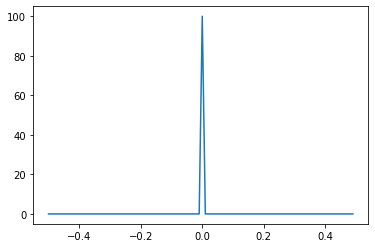

In [243]:
plt.plot(ax[:-1].detach(), ay.detach())

layer 2, name: Tanh, mean: -0.012337256222963333, std: 0.7010641098022461, saturation: 16.34375. shape: torch.Size([32, 100])
layer 5, name: Tanh, mean: -0.02288888767361641, std: 0.7399892210960388, saturation: 19.125. shape: torch.Size([32, 100])
layer 8, name: Tanh, mean: -0.003322458593174815, std: 0.7662690281867981, saturation: 19.03125. shape: torch.Size([32, 100])
layer 11, name: Tanh, mean: 0.01817997172474861, std: 0.7867134213447571, saturation: 20.78125. shape: torch.Size([32, 100])
layer 14, name: Tanh, mean: -0.012707258574664593, std: 0.805060625076294, saturation: 23.0. shape: torch.Size([32, 100])


Text(0.5, 1.0, 'activation distribution')

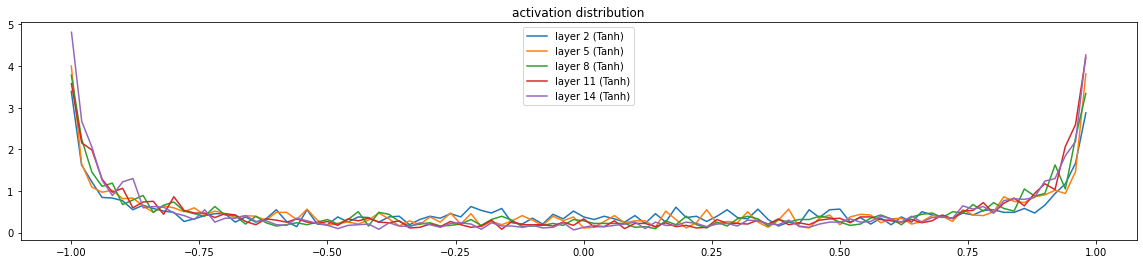

In [262]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        # print(layer)
        t = layer.out
        print(f'layer {i}, name: {layer.__class__.__name__}, mean: {t.mean()}, std: {t.std()}, saturation: {(t.abs() > 0.97).float().mean()*100}. shape: {t.shape}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

layer 2, name: Tanh, mean: 4.656612768993984e-12, std: 0.003181778360158205, saturation: 0.0. shape: torch.Size([32, 100])
layer 5, name: Tanh, mean: -2.444721682037798e-11, std: 0.0030643290374428034, saturation: 0.0. shape: torch.Size([32, 100])
layer 8, name: Tanh, mean: 5.8207661780829145e-12, std: 0.0031255127396434546, saturation: 0.0. shape: torch.Size([32, 100])
layer 11, name: Tanh, mean: -2.444721682037798e-11, std: 0.0034520456101745367, saturation: 0.0. shape: torch.Size([32, 100])
layer 14, name: Tanh, mean: -1.3969838306981952e-11, std: 0.003800155594944954, saturation: 0.0. shape: torch.Size([32, 100])


Text(0.5, 1.0, 'gradient distribution')

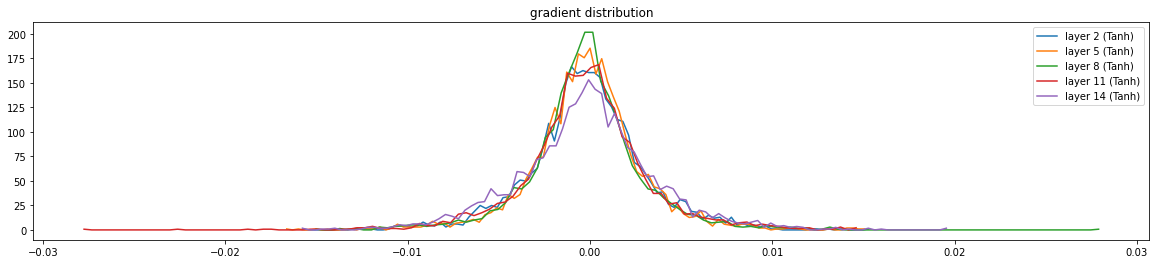

In [264]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        # print(layer)
        t = layer.out.grad
        # print(t)
        print(f'layer {i}, name: {layer.__class__.__name__}, mean: {t.mean()}, std: {t.std()}, saturation: {(t.abs() > 0.97).float().mean()*100}. shape: {t.shape}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')

layer 0, mean: -5.51894849265544e-11, std: 0.013697515241801739, shape: torch.Size([27, 10]), grad:data ration: 0.011946500279009342
layer 1, mean: 5.935395893175155e-05, std: 0.006413943134248257, shape: torch.Size([30, 100]), grad:data ration: 0.014302555471658707
layer 4, mean: 5.8959591115126386e-05, std: 0.004179060459136963, shape: torch.Size([100, 100]), grad:data ration: 0.015330225229263306
layer 7, mean: -7.826052751624957e-05, std: 0.004397868644446135, shape: torch.Size([100, 100]), grad:data ration: 0.016381682828068733
layer 10, mean: 2.1702257072320208e-05, std: 0.00455399788916111, shape: torch.Size([100, 100]), grad:data ration: 0.017449717968702316
layer 13, mean: -1.8675782484933734e-05, std: 0.004726990591734648, shape: torch.Size([100, 100]), grad:data ration: 0.018761195242404938
layer 16, mean: 4.7339963202830404e-05, std: 0.008236318826675415, shape: torch.Size([100, 27]), grad:data ration: 0.022094376385211945


Text(0.5, 1.0, 'weights gradient distribution')

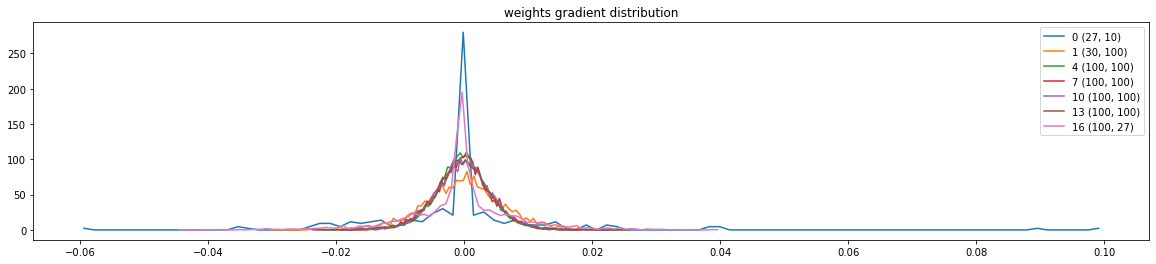

In [265]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if t.ndim == 2: # plot all the weights and skip biases
        # print(layer)
        # print(t)
        print(f'layer {i}, mean: {t.mean()}, std: {t.std()}, shape: {p.shape}, grad:data ration: {t.std() / p.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution')

In [268]:
len(parameters)

19

In [271]:
len(ud[0]), len(ud)

(19, 200000)

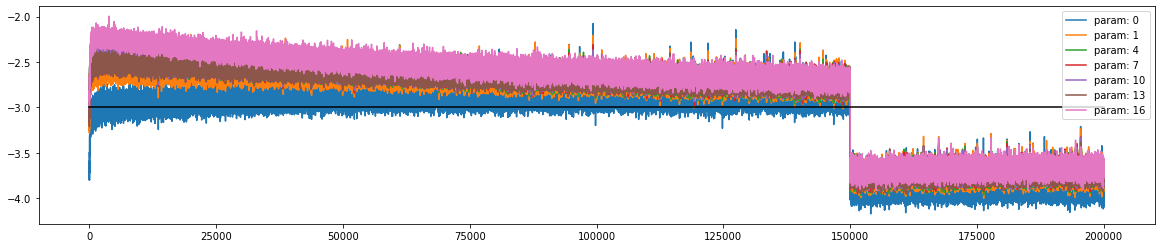

In [284]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param: {i}')

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be 1e-3 or close to it.
plt.legend(legends)

In [278]:
x = torch.linspace(0, 10, 10)
y = torch.linspace(0, 20, 10)
x, y

(tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
          8.8889, 10.0000]),
 tensor([ 0.0000,  2.2222,  4.4444,  6.6667,  8.8889, 11.1111, 13.3333, 15.5556,
         17.7778, 20.0000]))

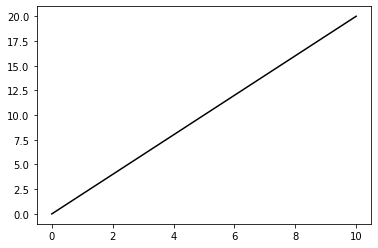

In [280]:
plt.plot(x, y, 'k')

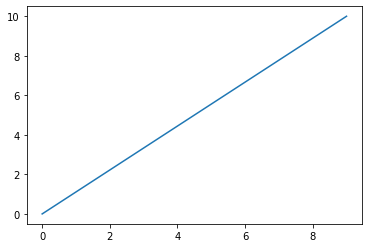

In [281]:
plt.plot(x)

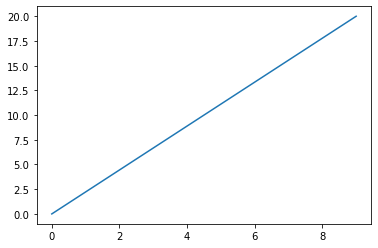

In [282]:
plt.plot(y)

In [266]:
# calculate loss

@torch.no_grad()
def split_loss(split):
    x,y = datasets[split]
    emb = C[x]
    x = emb.view(x.shape[0], -1)
    for layer  in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [267]:
for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')

train 2.003933906555176
val 2.080632448196411


In [ ]:
# sample from the model

In [285]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # [1, block_size, n_embed]
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)

        logits = x
        probs = F.softmax(logits)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahfari.
harlin.
mili.
tatyah.
cassie.
rah.
bradheryncia.
qui.
nellara.
chaiivia.
legyn.
ham.
joce.
quintis.
lilah.
jadilyn.
jero.
dearyn.
kai.
eveiluan.


/var/folders/c8/mt_y_mg14_s14_slht8ds95w0000gn/T/ipykernel_46166/1635156332.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


In [ ]:
# Pytorch implementation

In [286]:
import torch.nn as nn

In [287]:
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    nn.Linear(n_embed * block_size, n_hidden, bias=True), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size, bias=False), nn.BatchNorm1d(vocab_size),
]

In [147]:
x = torch.randn(32, 30)
print(x.shape)

torch.Size([32, 30])


# Check batchnorm stats

In [288]:
g = torch.Generator().manual_seed(2147483647)

In [291]:
a = torch.randn((1000, 1), requires_grad=True, generator=g)
b = torch.randn((1000, 1000), requires_grad=True, generator=g)
c = b @ a # [1000, 1]
loss = torch.randn(1000, generator=g) @ c # [1, 1]
print(loss.shape)
c.retain_grad()
loss.backward()

print(a.std().item(), b.std().item(), c.std().item())
print('gradient values')
print(a.grad.std().item(), b.grad.std().item(), c.grad.std().item())

torch.Size([1])
1.000772476196289 1.0003255605697632 31.688983917236328
gradient values
31.432523727416992 1.0009249448776245 0.9978907704353333


In [299]:
a = torch.randn((1000, 1), requires_grad=True, generator=g)
b = torch.randn((1000, 1000), requires_grad=True, generator=g)
c = b @ a # [1000, 1]

# apply batch norm
cmean = c.mean()
cvar = c.var()
out = (c - cmean) / torch.sqrt(cvar + 1e-5)

loss = torch.randn(1000, generator=g) @ out # [1, 1]
print(loss.shape)

c.retain_grad()
out.retain_grad()
loss.backward()

print(a.std().item(), b.std().item(), c.std().item(), out.std().item())
print('gradient values')
print(a.grad.std().item(), b.grad.std().item(), c.grad.std().item(), out.grad.std().item())

torch.Size([1])
1.0164446830749512 0.9992260336875916 31.863162994384766 1.0
gradient values
0.9863744378089905 0.03182259574532509 0.03133050724864006 1.0000592470169067
